# Audio Classification with STFT Spectrogram based CNN and bird call count


In [1]:
!pip install -q kaggle

In [2]:
!pip install -q librosa

## Importing Dependencies

In [5]:
import os
import numpy as np
import matplotlib.pyplot  as plt
import tensorflow as tf
import tensorflow_io as tfio
import librosa
import librosa.display
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from IPython.display import Audio

/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutex6unlockEv']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZN3tsl7strings13safe_strtou64ESt17basic_string_viewIcSt11char_traitsIcEEPm']
  warnings.warn(

In [6]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d kenjee/z-by-hp-unlocked-challenge-3-signal-processing -p /content
!unzip -q /content/z-by-hp-unlocked-challenge-3-signal-processing.zip -d /content/dataset

Dataset URL: https://www.kaggle.com/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing
License(s): CC-BY-NC-SA-4.0
 97% 586M/604M [00:05<00:00, 68.5MB/s]
100% 604M/604M [00:06<00:00, 94.8MB/s]


In [9]:
POS_DIR = '/content/dataset/Parsed_Capuchinbird_Clips'
NEG_DIR = '/content/dataset/Parsed_Not_Capuchinbird_Clips'
FOREST_DIR = '/content/dataset/Forest Recordings'

In [10]:
FREQ_BINS = (1024 // 2) + 1

In [11]:
def load_process_audio(file_path,label):
  def process_audio(file_path,label):
    file_path = file_path.numpy().decode('utf-8')
    audio,sr = librosa.load(file_path,sr=16000,mono=True)

    target_length = 16000 * 3
    if len(audio) > target_length:
      audio = audio[:target_length]
    else:
      audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')

    stft = librosa.stft(audio,n_fft=1024,hop_length=512) # Computing STFT Spectrogram
    spectrogram = np.abs(stft)
    spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max) # coverting to log-scale (dB)

    spectrogram_db = (spectrogram_db - spectrogram_db.min()) / (spectrogram_db.max() - spectrogram_db.min())

    spectrogram_db = spectrogram_db[..., np.newaxis]
    return spectrogram_db.astype(np.float32), label

  spectrogram,label = tf.py_function(
      process_audio,
      [file_path,label],
      [tf.float32,tf.int32]
  )

  spectrogram.set_shape([FREQ_BINS,94,1])
  label.set_shape([])

  return spectrogram,label



## Function for displaying Spectrogram

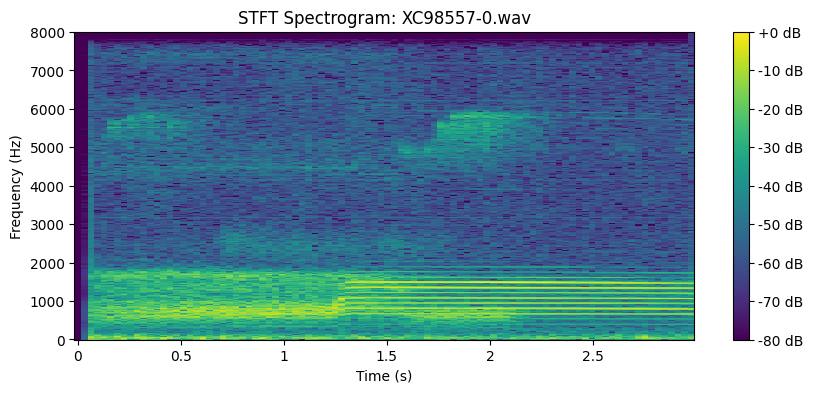

In [ ]:
def get_spectrogram(file_path):

    audio, sr = librosa.load(file_path, sr=16000, mono=True)

    target_length = 16000 * 3
    if len(audio) > target_length:
        audio = audio[:target_length]
    else:
        audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')

    stft = librosa.stft(audio, n_fft=1024, hop_length=512)
    spectrogram = np.abs(stft)
    spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
    return spectrogram_db, audio, sr


sample_file = os.path.join(POS_DIR, os.listdir(POS_DIR)[0])  # First WAV file
spectrogram_db, audio, sr = get_spectrogram(sample_file)

# Plot spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(
    spectrogram_db,
    sr = 16000,
    hop_length=512,
    x_axis='time',
    y_axis='hz',
    cmap='viridis'
)
plt.colorbar(format='%+2.0f dB')
plt.title(f'STFT Spectrogram: {os.path.basename(sample_file)}')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [12]:
def create_dataset(pos_dir, neg_dir):
    pos_files = [os.path.join(pos_dir, f) for f in os.listdir(pos_dir) if f.endswith('.wav')]
    neg_files = [os.path.join(neg_dir, f) for f in os.listdir(neg_dir) if f.endswith('.wav')]
    files = pos_files + neg_files
    labels = [1] * len(pos_files) + [0] * len(neg_files)
    dataset = tf.data.Dataset.from_tensor_slices((files, labels))
    dataset = dataset.map(load_process_audio, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1000).batch(16).prefetch(tf.data.AUTOTUNE)
    return dataset

In [13]:
full_dataset = create_dataset(POS_DIR, NEG_DIR)
dataset_size = len(list(full_dataset.unbatch()))
train_size = int(0.8 * dataset_size)
train_dataset = full_dataset.take(train_size // 16)  # Adjusted for batch size
test_dataset = full_dataset.skip(train_size // 16)

In [14]:
def create_cnn_model(input_shape=(FREQ_BINS, 94, 1)):
  model = tf.keras.Sequential([

      tf.keras.layers.Input(shape=input_shape),
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu',padding='same'),
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1, activation='sigmoid')

    ])

  return model


model = create_cnn_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision()])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 513, 94, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 256, 47, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 47, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 23, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 23, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 5, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    10,486,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,874,113 (41.48 MB)

 Trainable params: 10,874,113 (41.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 24s 248ms/step - loss: 0.7100 - precision: 0.3993 - val_loss: 0.4076 - val_precision: 1.0000
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 294ms/step - loss: 0.3484 - precision: 0.7803 - val_loss: 0.3677 - val_precision: 1.0000
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step - loss: 0.2024 - precision: 0.9244 - val_loss: 0.0714 - val_precision: 1.0000
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - loss: 0.0794 - precision: 0.9866 - val_loss: 0.0072 - val_precision: 1.0000
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - loss: 0.0265 - precision: 0.9928 - val_loss: 0.0441 - val_precision: 1.0000
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - loss: 0.0188 - precision: 1.0000 - val_loss: 0.0133 - val_precision: 1.0000
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step - loss: 0.0480 - precision: 1.0000 - val_loss: 0.0069 - val_precision: 1.0000
Epoch 8/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - loss: 0.0044 - precision: 1.

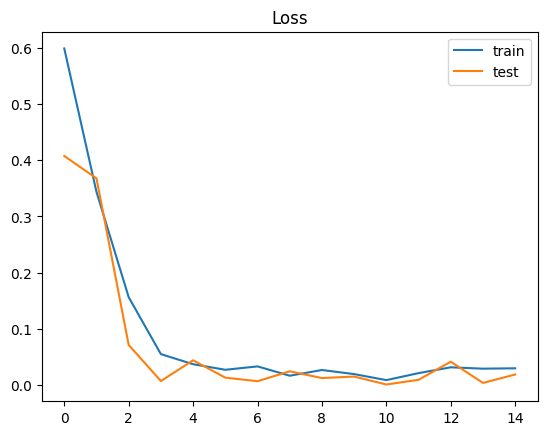

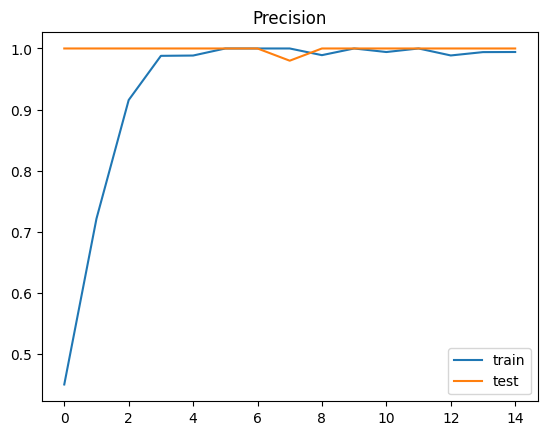

In [15]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs = 15,
    verbose=1
)

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

plt.title('Precision')
plt.plot(history.history['precision'], label='train')
plt.plot(history.history['val_precision'], label='test')
plt.legend()
plt.show()

In [16]:
def count_bird_calls (model,file_path,sample_rate = 16000,window_size = 3,stride=1,threshold = 0.5):
  audio,sr = librosa.load(file_path,sr=sample_rate,mono=True)
  window_samples = window_size * sample_rate
  stride_samples = stride * sample_rate
  count = 0
  for start in range(0,len(audio) - window_samples + 1,stride_samples):
    segment = audio[start:start + window_samples]
    if len(segment) < window_samples:
      segment = np.pad(segment, (0, window_samples - len(segment)), mode='constant')
    stft = librosa.stft(segment, n_fft=1024,hop_length=512)
    spectrogram = np.abs(stft)
    spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
    spectrogram_db = (spectrogram_db - spectrogram_db.min()) / (spectrogram_db.max() - spectrogram_db.min())
    spectrogram_db = spectrogram_db[np.newaxis, ..., np.newaxis]
    pred = model.predict(spectrogram_db, verbose=0)
    if pred[0][0] > threshold:
      count += 1
  return count

## Example Inference

In [17]:
forest_file = '/content/dataset/Forest Recordings/recording_00.mp3'
call_count = count_bird_calls(model,forest_file)
print(f"Number of bird calls in the {forest_file}: {call_count}")

Number of bird calls in the /content/dataset/Forest Recordings/recording_00.mp3: 24
